# text8 dataset

In [76]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [77]:
from gensim.test.utils import datapath
import gensim.downloader as api

"Transforms a list of words to a list of sentences with length=len_sen"
def words_to_sentences(words,len_sen=20):
    new_ds = []
    for i in range(0, len(words), len_sen):
        y = [words[i:i + len_sen]]
        new_ds.extend(y)
    return new_ds

# Get dataset online
dataset = api.load('text8')

# Convert to list of words
text8_ds = []
for x in dataset: 
    for y in x:
        text8_ds.append(y)

# New dataset with sentences of length=20
text8_dataset = words_to_sentences(text8_ds)


# Wordsim Task

In [78]:
from scipy import stats, spatial 
import csv, numpy as np
from scipy.stats.stats import pearsonr
from scipy import spatial 
#IMPORT DATA
def get_wordsim_data():
    wordsim_data = [] 
    with open('./data/wordsim/set1.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for row in reader: 
            wordsim_data.append(row[0].split(',')[0:3])
    del wordsim_data[0]
    with open('./data/wordsim/set2.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ',quotechar='|')
        for i,row in enumerate(reader):
            if i!=0:
                wordsim_data.append(row[0].split(',')[0:3])

    return wordsim_data

#len(wordsim_vocab.intersection(text8_dataset_first_sentence.vocab))
def wordsim_task(dict_emb):
    wordsim_data = get_wordsim_data()
    scores = []
    distances = []
    found = 0
    missed = 0
    for task in wordsim_data: 
        if (task[0] in dict_emb.keys() ) and (task[1] in dict_emb.keys()):
            found += 1
            scores.append(float(task[2]))
            distances.append(spatial.distance.cosine(dict_emb[task[0]], dict_emb[task[1]]))
        else:
            missed += 1
            
    print('found:',found,'missed:',missed)            
            
    #return stats.zscore(np.array([x[1] for x in out],dtype=float))
    return np.corrcoef(scores,distances)

# Model

In [79]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class SkipGramModel(nn.Module):

    def __init__(self, emb_size_u, emb_size_v,emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size_u, emb_dimension, sparse=False)
        self.v_embeddings = nn.Embedding(emb_size_v, emb_dimension, sparse=False)
        self.init_emb()
        

    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)
        
    def forward(self, pos_u, pos_v,neg_v):
        emb_u = self.u_embeddings(pos_u)
        neg_v = neg_v.view(len(pos_u),-1)
        samples = torch.cat([pos_v,Variable(neg_v)],1)
        emb_v = self.v_embeddings(samples)
        score = torch.bmm(emb_v, emb_u.unsqueeze(2)).squeeze()
        score[:,1:]=score[:,1:].neg()
        score = F.logsigmoid(score)
        return -1 * (torch.sum(score))

# Word2Vec Dataset

In [86]:
from torch.utils.data import Dataset
from collections import defaultdict
from gensim.models.doc2vec import TaggedDocument
import random
import multiprocessing
import time
import numbers
import itertools
import pdb


class W2VDataset(Dataset):
    def __init__(self, sentences,power=0.75, neg_samples=5, min_count=5, window=5, sample=1e-4, sample_buffer=1000):
        self.sentences = sentences
        self.neg_samples=neg_samples
        self.min_count = min_count
        self.window_size = window
        self.vocab_id = defaultdict(int)
        self.vocab_ctx = defaultdict(int)
        self.index2id = dict()
        self.id2index = dict()
        self.index2ctx = dict()
        self.ctx2index = dict()
        self.build_vocab(sentences)
        self.ctx_weights = self.make_cum_table(power)
        self.downsample_probs = np.zeros_like(self.ctx_weights)
        if sample > 0:
            self.downsample_probs = 1 - np.sqrt(sample/self.ctx_weights).clip(0,1)
        self.pairs = []
        ### If you do not want to shuffle the pairs please selec generat_pairs, else you can generate the pairs 
        ### in parallel with generate_pairs_parallel()
        self.generate_pairs()
        #self.generate_pairs_parallel()
        self.ctx_weights = torch.FloatTensor(self.ctx_weights)
        self.samples = None
        self.sample_idx = -1
        self.sample_size = 0
        self.sample_buffer = sample_buffer
        
    def dataset_into_chunks(self,dataset,n_chunks=15):
        chunks = []
        #print(type(n_chunks))
        split = int((len(dataset)/(n_chunks-1)))
        for i in range(0, len(dataset), split):
                    y = [dataset[i:i + split]]
                    chunks.extend(y)
        return chunks
    def chunks_to_ds(chunks): 
        out = [x for z in l for x in chunks]
        return out
        
    def sliding_window(self, words):
        for pos, word in enumerate(words):
            # sliding window (randomly reduced to give more weight to closeby words)
            reduction = np.random.randint(self.window_size)
            start = max(0, pos - self.window_size + reduction)
            for pos2, word2 in enumerate(words[start:(pos + self.window_size + 1 - reduction)], start):
                if pos2 != pos:
                    yield (self.id2index[word],self.id2index[word2])
                    
    def generate_pairs_inner(self,sent):
        pairs = []
        words = [w for w in sent if w in self.vocab_id and self.downsample_probs[self.id2index[w]] < random.random()]
        for pair in self.sliding_window(words):
            pairs.append(pair)
        return pairs
        
    def generate_pairs(self):  
        print('generating pairs')
        start = time.time()
        p = [self.generate_pairs_inner(s) for s in self.sentences]
        self.pairs = list(itertools.chain(*p))
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
        print('pairs generated in ',time_since_start)

    def generate_pairs_parallel(self): 
        print('generating pairs parallel')
        start = time.time()
        chunks = self.dataset_into_chunks(self.sentences)
        manager = multiprocessing.Manager()
        return_dict = manager.list()
        threads = []
        pairs = []
        for index,chunk in enumerate(chunks):
            thread = multiprocessing.Process(target=self.generate_pairs_single_thread, args=(chunk,index,return_dict))
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
        
    
        self.pairs = list(itertools.chain(*return_dict))
        
        end = time.time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
        print('pairs generated parallel  in ',time_since_start)
        
    def generate_pairs_single_thread(self,chunk,index,return_dict):
        pairs = []
        for sent in chunk:
            words = [w for w in sent if w in self.vocab_id and self.downsample_probs[self.id2index[w]] < random.random()]
            for pair in self.sliding_window(words):
                pairs.append(pair)
        #p = [self.generate_pairs_inner(s) for s in chunk]
        #out = list(itertools.chain(*p))
        print('thread' + str(index) + ' created' + str(len(pairs)) + " pairs")
        return_dict.extend(pairs)
        #return_dict[index] = pairs
      
        
    def build_vocab(self,sentences):
        print('building vocab')
        raw_vocab = defaultdict(int)
        for sent in sentences:
            for word in sent:
                raw_vocab[word] += 1
        self.vocab_id = {k:v for k,v in raw_vocab.items() if v >= self.min_count}
        self.vocab_ctx = self.vocab_id 
        del raw_vocab
                
        # ctx - index
        for word in self.vocab_ctx:
            self.ctx2index[word] = len(self.ctx2index)
        self.index2ctx = dict(zip(self.ctx2index.values(), self.ctx2index.keys()))
        # id - index
        self.id2index = self.ctx2index
        self.index2id = self.index2ctx
        print('vocab build')
        
        
    def make_cum_table(self, power):
        pow_frequency = np.array([self.vocab_ctx[self.index2ctx[i]] for i in range(len(self.vocab_ctx))])**power
        return pow_frequency / pow_frequency.sum()
    
    
    def sample_neg(self, count):
        if self.sample_idx == -1:
            self.sample_size = count*self.sample_buffer
            self.samples = np.random.choice(list(self.index2ctx.keys()),size=self.sample_size,replace=True,p=self.ctx_weights)
            self.sample_idx = 0
        while self.sample_idx + count > len(self.samples):
            self.samples = np.random.choice(list(self.index2ctx.keys()),size=self.sample_size,replace=True,p=self.ctx_weights)
            self.sample_idx = 0
        out = self.samples[self.sample_idx:self.sample_idx+count]
        self.sample_idx += count
        return out
        
        
    def __len__(self):
        return len(self.pairs)
    
    
    def __getitem__(self, idx):
        pos_u = self.pairs[idx][0]
        pos_v = self.pairs[idx][1]
        samples = self.sample_neg(self.neg_samples)
        while pos_v in samples:
            samples = self.sample_neg(self.neg_samples)
        return (pos_u,pos_v,samples)

# W2V Training

In [87]:
import torch
import pickle
from torch.utils.data import DataLoader
import copy
import time
import numbers

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')
gpu = torch.device("cuda:0")

class W2V():
    def __init__(self, data,dim=100, neg_samples=10, alpha=0.4, iterations=20, batch_size=2000, 
                 shuffle=True,use_cuda=True,workers=2,momentum=0,nesterov=False,step_size=1,gamma=1,optim='Adam'):
        self.momentum = momentum
        self.nesterov = nesterov
        self.step_size = step_size
        self.gamma = gamma
        self.shuffle = shuffle        
        self.batch_size = batch_size
        self.alpha = alpha
        self.dim = dim
        self.data = data
        self.workers = workers
        self.neg_samples = neg_samples
        self.use_cuda = use_cuda
        self.ws_list = []
        self.loss_list = []
        self.model = SkipGramModel(len(self.data.vocab_id),len(self.data.vocab_id), self.dim)
        self.model.to(device)
        # Choose wanted optimizer
        if (optim=='Adam'):
            print("choosen optimizer is Adam")
            self.optimizer = torch.optim.Adam(self.model.parameters(),lr=alpha)
        else:
            print("choosen optimizer is SGD")
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=alpha, momentum=momentum,nesterov=nesterov)
        
        


        self.iterations = iterations
 
    def train_with_loader(self,save_embedding=False):
        print('starting training')

        self.time=0
        for epoch in range(self.iterations):
            loader = DataLoader(self.data, self.batch_size, self.shuffle, num_workers=self.workers,pin_memory=True)
            tenth = int(len(loader)/10)

            percent = 0
            start = time.time()
            processed_batches = 0 
            pairs = 0
            cum_loss = 0 
            avg_loss =0
            best_loss = 10 
            
            for i,(pos_u,pos_v,neg_v) in enumerate(loader):
                if(i%tenth == 0 ):
                    end = time.time()
                    hours, rem = divmod(end-start, 3600)
                    minutes, seconds = divmod(rem, 60)
                    time_since_start = "Time:  {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)
                    if(processed_batches!=0):
                        avg_loss = cum_loss / processed_batches
                    print("0%" + "=" *(int(percent/10))+ str(percent) +"%, " + time_since_start + ", cum_loss = {}".format(cum_loss),end="\r" )
                    percent+=10   
                    
                pos_v = pos_v.view(len(pos_u),-1)
                neg_v = neg_v.view(len(pos_u),-1)
                pos_u = pos_u.to(device)
                pos_v = pos_v.to(device)
                neg_v = neg_v.to(device)
                self.optimizer.zero_grad()
                loss = self.model.forward(pos_u,pos_v,neg_v)
                cum_loss += loss
                loss.backward()
                self.optimizer.step()
                pairs += len(pos_u)
                processed_batches += 1
                
            print("\n{0:d} epoch of {1:d}".format(epoch+1, self.iterations))
            avg_loss = cum_loss / processed_batches
            print(" {0:d} {1:d} batches, pairs {2:d}, cum loss: {3:.5f}".format(i,processed_batches, pairs,cum_loss))
            self.loss_list.append(cum_loss)
            self.time = time_since_start
            self.model = self.model.to(cpu)
            score = -1*(wordsim_task(self.get_embedding())[0][1])
            print("Current score on wordsim Task: {}".format(score))
            self.ws_list.append(score)
            self.model = self.model.to(gpu)
            self.data.generate_pairs()
        
        if(save_embedding):
            self.save_embedding()
            

    def get_embedding(self):
        embedding_dict = dict()
        embedding = self.model.u_embeddings.weight.data.numpy()
        for i in range(len(self.data.index2id)):
            embedding_dict[self.data.index2id[i]]= embedding[i]
        return embedding_dict
    
    def save_embedding(self, with_loss=True):
        print('ntm')
        # Creating filename
        optim = "Optim" + str(self.optimizer).split(" ")[0] + "_"
        filename = "dict_emb_" +  optim + "_".join([x + str(y) for x,y in vars(self).items() if isinstance(y, numbers.Number)]) + ".pkl"
        
        # Getting Embedding
        self.model.to(torch.device('cpu'))
        dict_emb = w2v.get_embedding()
        
        # Adding loss history to embedding
        dict_emb['loss_list'] = [x.to(torch.device('cpu')) for x in self.loss_list]
        
        # Adding score list to embedding 
        dict_emb['ws_list'] = self.ws_list
        
                
        # Saving time spent to calculate 1 epoch
        dict_emb['time'] = self.time
        
        # Logging
        print("Saving embedding: {} to disk with ws_score: {} ".format(filename,dict_emb['ws_list']))
    
        # Writing embedding dictionnary to disk
        with open(filename, 'wb') as output:
            pickle.dump(dict_emb, output, pickle.HIGHEST_PROTOCOL)
        
        self.model.to(device)
        self.loss_list = [x.to(device) for x in self.loss_list]

### Building the dataset

In [88]:
neg_samples = 10
w2v_dataset = W2VDataset(text8_dataset,sample_buffer=500000,neg_samples=neg_samples)

building vocab
vocab build
generating pairs
pairs generated in  Time:  00:00:00.34


### Training without shuffling 

In [89]:
import pickle

ws_lists_adam_shuffle = []
ws_lists_sgd_shuffle = []
ADAM_LR = 0.001
SGD_LR = 0.075
NUMBER_OF_ITER = 10 
for x in range(NUMBER_OF_ITER):
    w2v = W2V(w2v_dataset, neg_samples=neg_samples, alpha=ADAM_LR,shuffle=False,workers=4,iterations=2,batch_size=2000,optim='Adam')
    w2v.train_with_loader()
    ws_lists_adam_shuffle.append(w2v.ws_list)
    
mean_list_adam = np.mean(ws_lists_adam_shuffle, axis=0)
with open('mean_list_adam.pkl', 'wb') as fp:
    pickle.dump(mean_list_adam, fp)
    
for x in range(NUMBER_OF_ITER):
    w2v = W2V(w2v_dataset, neg_samples=neg_samples, alpha=SGD_LR,shuffle=False,workers=4,iterations=2,batch_size=2000,optim='Sgd')
    w2v.train_with_loader()
    ws_lists_sgd_shuffle.append(w2v.ws_list)
mean_list_sgd = np.mean(ws_lists_sgd_shuffle, axis=0)
with open('mean_list_sgd.pkl', 'wb') as fp:
    pickle.dump(mean_list_sgd, fp)


choosen optimizer is Adam
starting training
0%==========100%, Time:  00:00:17.21, cum_loss = 1438224.5
1 epoch of 2
 108 109 batches, pairs 217181, cum loss: 1543223.37500
found: 133 missed: 220
Current score on wordsim Task: -0.0441667577714002
generating pairs
pairs generated in  Time:  00:00:00.43


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pi

  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


0%==========100%, Time:  00:00:18.02, cum_loss = 990942.0625
2 epoch of 2
 108 109 batches, pairs 217057, cum loss: 1064592.50000
found: 133 missed: 220
Current score on wordsim Task: -0.059125433955171496
generating pairs
pairs generated in  Time:  00:00:00.44
choosen optimizer is Adam
starting training


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pi

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fefb9b686a8>
Traceback (most recent call last):
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pi

0%=========90%, Time:  00:00:16.35, cum_loss = 1424383.125
1 epoch of 2
 109 110 batches, pairs 218500, cum loss: 1550297.37500
found: 133 missed: 220
Current score on wordsim Task: -0.09838665929188849
generating pairs
pairs generated in  Time:  00:00:00.53
0%=========90%, Time:  00:00:15.79, cum_loss = 980015.8125
2 epoch of 2
 109 110 batches, pairs 218768, cum loss: 1070159.50000
found: 133 missed: 220
Current score on wordsim Task: -0.10461219172327578
generating pairs
pairs generated in  Time:  00:00:00.45
choosen optimizer is SGD
starting training
0%=========90%, Time:  00:00:15.88, cum_loss = 2.0362532120636538e+23
1 epoch of 2
 109 110 batches, pairs 218726, cum loss: 510587539896671121436573696.00000
found: 133 missed: 220
Current score on wordsim Task: 0.029912766020889582
generating pairs


/usr/lib/python3.7/site-packages/scipy/spatial/distance.py:702: RuntimeWarning: overflow encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


pairs generated in  Time:  00:00:00.45
0%==========100%, Time:  00:00:16.87, cum_loss = nan99404906e+36
2 epoch of 2
 108 109 batches, pairs 216897, cum loss: nan
found: 133 missed: 220
Current score on wordsim Task: nan
generating pairs
pairs generated in  Time:  00:00:00.54
choosen optimizer is SGD
starting training
0%==========100%, Time:  00:00:15.43, cum_loss = 2.870314530790711e+24
1 epoch of 2
 108 109 batches, pairs 217330, cum loss: 1140528244068365950842306560.00000
found: 133 missed: 220
Current score on wordsim Task: 0.07805356897029156
generating pairs
pairs generated in  Time:  00:00:00.44
0%=========90%, Time:  00:00:16.62, cum_loss = nan26037533e+36
2 epoch of 2
 109 110 batches, pairs 218354, cum loss: nan
found: 133 missed: 220
Current score on wordsim Task: nan
generating pairs
pairs generated in  Time:  00:00:00.43


### Training with shuffling

In [91]:
ws_lists_adam_shuffle = []
ws_lists_sgd_shuffle = []
ADAM_LR = 0.005
SGD_LR = 0.05
NUMBER_OF_ITER = 10
for x in range(NUMBER_OF_ITER):
    w2v = W2V(w2v_dataset, neg_samples=neg_samples, alpha=ADAM_LR,shuffle=True,workers=4,iterations=3,batch_size=2000,optim='Adam')
    w2v.train_with_loader()
    ws_lists_adam_shuffle.append(w2v.ws_list)
    
mean_list_adam_shuffle = np.mean(ws_lists_adam_shuffle, axis=0)
with open('mean_list_adam_shuffle.pkl', 'wb') as fp:
    pickle.dump(mean_list_adam_shuffle, fp)

for x in range(NUMBER_OF_ITER):
    w2v = W2V(w2v_dataset, neg_samples=neg_samples, alpha=SGD_LR,shuffle=True,workers=4,iterations=3,batch_size=2000,optim='Sgd')
    w2v.train_with_loader()
    ws_lists_sgd_shuffle.append(w2v.ws_list)
    
mean_list_sgd_shuffle = np.mean(ws_lists_sgd_shuffle, axis=0)
with open('mean_list_sgd_shuffle.pkl', 'wb') as fp:
    pickle.dump(mean_list_sgd_shuffle, fp)


choosen optimizer is Adam
starting training
0%==========100%, Time:  00:00:18.31, cum_loss = 894471.55
1 epoch of 3
 108 109 batches, pairs 217094, cum loss: 951646.12500
found: 133 missed: 220
Current score on wordsim Task: 0.15503581852895157
generating pairs
pairs generated in  Time:  00:00:00.47
0%==========100%, Time:  00:00:20.00, cum_loss = 668822.55
2 epoch of 3
 108 109 batches, pairs 216396, cum loss: 723614.87500
found: 133 missed: 220
Current score on wordsim Task: 0.18099295449582226
generating pairs
pairs generated in  Time:  00:00:00.53
0%==========100%, Time:  00:00:18.49, cum_loss = 664265.5
3 epoch of 3
 108 109 batches, pairs 217142, cum loss: 720741.75000
found: 133 missed: 220
Current score on wordsim Task: 0.1908839621932184
generating pairs
pairs generated in  Time:  00:00:00.44
choosen optimizer is Adam
starting training
0%==========100%, Time:  00:00:22.27, cum_loss = 893750.6875
1 epoch of 3
 108 109 batches, pairs 217645, cum loss: 952836.25000
found: 133 mis

### Training Gensim



In [92]:
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec
gensim_emb = dict()
    
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.cum_loss = 0
        self.loss_list = []
        self.ws_list = []
        self.prev_score = -1
        self.no_improvement =0

    def on_epoch_end(self, model):
        score = model.wv.evaluate_word_pairs("./data/wordsim/combined.tab")
        self.ws_list.append(score[1][0])
        print("Epoch #{}, ws_score={}".format(self.epoch,score[1][0]))
        self.epoch += 1 
            
    def on_batch_end(self, model):
        """Method called at the end of each batch.
        Parameters
        ----------
        model : :class:`~gensim.models.base_any2vec.BaseWordEmbeddingsModel`
            Current model.
        """
        self.cum_loss += model.get_latest_training_loss()
        

In [93]:
ws_lists_gensim  = []
for x in range(NUMBER_OF_ITER):
    epoch_logger = EpochLogger()
    model = Word2Vec(text8_dataset,size=100,window=5,negative=10,min_count=5, sample=1e-4, iter=10, workers=1,sg=1, hs=0,callbacks=[epoch_logger],compute_loss=True)
    ws_lists_gensim.append(epoch_logger.ws_list)
mean_list_gensim = np.mean(ws_lists_gensim, axis=0)
with open('mean_list_gensim.pkl', 'wb') as fp:
    pickle.dump(mean_list_gensim, fp)

Epoch #0, ws_score=0.18423471143533865
Epoch #1, ws_score=0.1504900618701916
Epoch #2, ws_score=0.15069705990034016
Epoch #3, ws_score=0.12675403013767464
Epoch #4, ws_score=0.10829377315375806
Epoch #0, ws_score=0.18423471143533865
Epoch #1, ws_score=0.1504900618701916
Epoch #2, ws_score=0.15069705990034016
Epoch #3, ws_score=0.12675403013767464
Epoch #4, ws_score=0.10829377315375806


### Vizualization

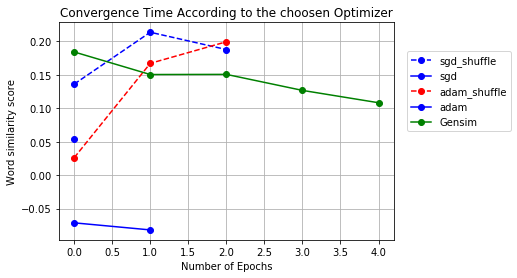

In [94]:
import numpy as np
import matplotlib.pyplot as plt
plt.xlabel('Number of Epochs')
plt.ylabel('Word similarity score')
plt.title('Convergence Time According to the choosen Optimizer')
# red dashes, blue squares and green triangles
plt.plot(mean_list_sgd_shuffle, 'bo--',label='sgd_shuffle')
plt.plot(mean_list_sgd , 'bo-',label='sgd')
plt.plot(mean_list_adam_shuffle,'ro--',label='adam_shuffle')
plt.plot(mean_list_adam,'ro-',label='adam')
plt.plot(mean_list_gensim,'go-',label='Gensim')
plt.grid(True)
plt.legend(loc=(1.04,0.5))
plt.savefig('comparison.png')
plt.show()
